# RQ6 Posting Effectiveness

For this question, we need to consider two datasets:
* instagram_profiles
* instagram_posts

## Finding the average time a user lets pass
To find the average time a user lets pass before posting another post, one can do the following:
1. Get all profiles from the profiles dataset.
2. For each profile, find the maximum and minimum post time in the posts dataset.
3. Find the average by subtracting the minimum post time from the maximum post time and dividing by the number of posts the profile has.
4. Take the average of all post frequency averages.

### Caveats:
* Not all profiles that appear in the profiles dataset also appear in the posts dataset (even if they have posts). Since we care about finding the average time, a user MUST exist in the posts dataset for the analysis to be conclusive.
* The number of posts for each profile shown in the profiles dataset is unreliable, meaning that it doesn't mean that all those posts will be found in the posts dataset.

### Choices:
* Only consider users that appear in both posts and profiles dataset.
* Remove posts that don't have a post time.

### Approach
The profiles dataset has over 4 million rows and posts dataset has over 40 million rows. Finding all of the rows that belong to each user using pandas queries is very expensive, as all 40 million rows need to be scanned for each profile in the profiles dataset.

Instead of relying on querying, the rows belonging to each user are retrieved using indexing instead which is an O(1) operation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
import numpy as np
from posts.publishing import find_posts_between
from posts import timedelta_to_days_minutes
from tqdm import tqdm

## Cleaning profiles dataset
To find the posts for each profile, we need to first need to make sure that profiles contains no duplicates and nulls.

In [2]:
profiles = pd.read_csv('data/instagram_profiles.csv', sep='\t', usecols=['profile_id', 'profile_name', 'n_posts', 'following', 'followers'])
profiles = profiles[profiles.profile_id.notnull()]
profiles.profile_id = profiles.profile_id.astype('Int64')
profiles = profiles.drop_duplicates(subset='profile_id', keep="last")
profiles = profiles.sort_values(by='profile_id')

## Cleaning posts dataset
We only want posts that are associated with profiles in the profiles dataset, so will remove nulls and only keep rows where the profile_id exists in the profiles dataset.

In [3]:
posts = pd.read_csv('data/instagram_posts.csv', sep='\t', usecols=['profile_id', 'cts', 'numbr_likes', 'number_comments'], parse_dates=['cts'], index_col=False)

In [4]:
profile_time = posts[['profile_id', 'cts']]

In [5]:
filtered_posts = profile_time.dropna()
filtered_posts = filtered_posts[filtered_posts.profile_id.isin(profiles.profile_id)]
sorted_posts = filtered_posts.sort_values(by='profile_id')

In [6]:
profiles_with_posts = profiles[profiles.profile_id.isin(sorted_posts.profile_id.unique())]

In [7]:
# count the actual number of posts
profiles_with_posts['true_n_posts'] = sorted_posts.groupby('profile_id')['profile_id'].count().values

C:\Users\Jonas\AppData\Local\Temp\ipykernel_11200\4124026347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts['true_n_posts'] = sorted_posts.groupby('profile_id')['profile_id'].count().values


In [8]:
sorted_post_times = sorted_posts.cts.values

In [9]:
# Find the indeces
profiles_with_posts['start_index'] = profiles_with_posts.true_n_posts.shift(1)
profiles_with_posts.start_index = profiles_with_posts.start_index.cumsum().astype('Int64')
profiles_with_posts.iloc[0, -1] = 0

C:\Users\Jonas\AppData\Local\Temp\ipykernel_11200\1224487006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts['start_index'] = profiles_with_posts.true_n_posts.shift(1)
C:\Users\Jonas\AppData\Local\Temp\ipykernel_11200\1224487006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts.start_index = profiles_with_posts.start_index.cumsum().astype('Int64')


In [10]:
def find_time_stamps(profile_id, n_posts, start_index):

    start_index = int(start_index)
    n_posts = int(n_posts)
    profile_post_times = sorted_post_times[start_index:start_index + n_posts]
    
    min_post_time = profile_post_times.min()
    max_post_time = profile_post_times.max()
  
    return max_post_time, min_post_time

In [11]:
max_post, min_post = np.vectorize(find_time_stamps)(profiles_with_posts.profile_id, profiles_with_posts.true_n_posts, profiles_with_posts.start_index)

In [12]:
profiles_with_posts['max_post'] = max_post
profiles_with_posts['min_post'] = min_post

C:\Users\Jonas\AppData\Local\Temp\ipykernel_11200\1394401756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts['max_post'] = max_post
C:\Users\Jonas\AppData\Local\Temp\ipykernel_11200\1394401756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts['min_post'] = min_post


In [13]:
profiles_with_posts['post_time_delta'] = profiles_with_posts.max_post - profiles_with_posts.min_post
profiles_with_posts['avg_post_delta'] = profiles_with_posts.post_time_delta / (profiles_with_posts.true_n_posts - 1)

C:\Users\Jonas\AppData\Local\Temp\ipykernel_11200\1947825743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts['post_time_delta'] = profiles_with_posts.max_post - profiles_with_posts.min_post
C:\Users\Jonas\AppData\Local\Temp\ipykernel_11200\1947825743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts['avg_post_delta'] = profiles_with_posts.post_time_delta / (profiles_with_posts.true_n_posts - 1)


### What is the average time (days and minutes) a user lets pass before publishing another post?

#### How to answer this question
1. Get all profiles from the `profiles.csv` dataset. 
2. For each profile, find the maximum and minimum post time in the `posts.csv` dataset.
3. Find the average by subtracting the minimum post time from the maximum post time and dividing by the number of posts the profile has.
4. Take the average of all post frequency averages.

The answer to this question is somewhat distorted by people who have either posted 0 or 1 posts. In both scenarios, the average post time will be 0, which doesn't contribute to increasing the cumulative average post time of all users.

Hence, users with 0 or 1 posts reduce the overall average post time.

In [14]:
days, minutes = timedelta_to_days_minutes(profiles_with_posts.avg_post_delta.mean())
print(f"Average time for a user lets pass before publishing another post, taking into account users who were found to have posted, is {days} days and {minutes} minutes.")

Average time for a user lets pass before publishing another post, taking into account users who were found to have posted, is 30 days and 127 minutes.


### Plot the top 3 users that publish posts more frequently (calculate the average time that passes between posts), including their amount of followers and following. Provide insights from that chart.

Plotting the top 3 users that publish posts more frequently does not provided any valuable insights. There are a number of users with more that posted multiple posts at the same time and therefore have a post frequency of 0. For that reason, the post frequency dimension does not make a difference in the plot.

By plotting the average time that passes between posts, the number of followers, and the number of following, for all users, we can more easily see whether there is a pattern.

In [15]:
filtered_profiles = profiles_with_posts[profiles_with_posts.true_n_posts > 1]

In [16]:
top_3 = profiles_with_posts.sort_values(by='avg_post_delta').head(3)
top_3[['profile_name', 'followers', 'following', 'avg_post_delta']]

,profile_name,followers,following,avg_post_delta
3793471,bassamaludovic5522,59.0,139.0,0 days
2445653,alex_dinsdale,705.0,1572.0,0 days
1083546,twine_9,30.0,1009.0,0 days


In [17]:
seconds = filtered_profiles.avg_post_delta.dt.total_seconds()
followers = filtered_profiles.followers
following = filtered_profiles.following

#### Plotting all users
The plot below shows the average time between posts, number of followers, and number of following for all users that have posts in the `posts` dataset.

From the plot, we can see that users that have more than 1,000 followers, wait an average time of more than 10,000 seconds (2h 45 minutes) before making another post.

We can also see that users with fewer followers, also generally follow fewer other profiles

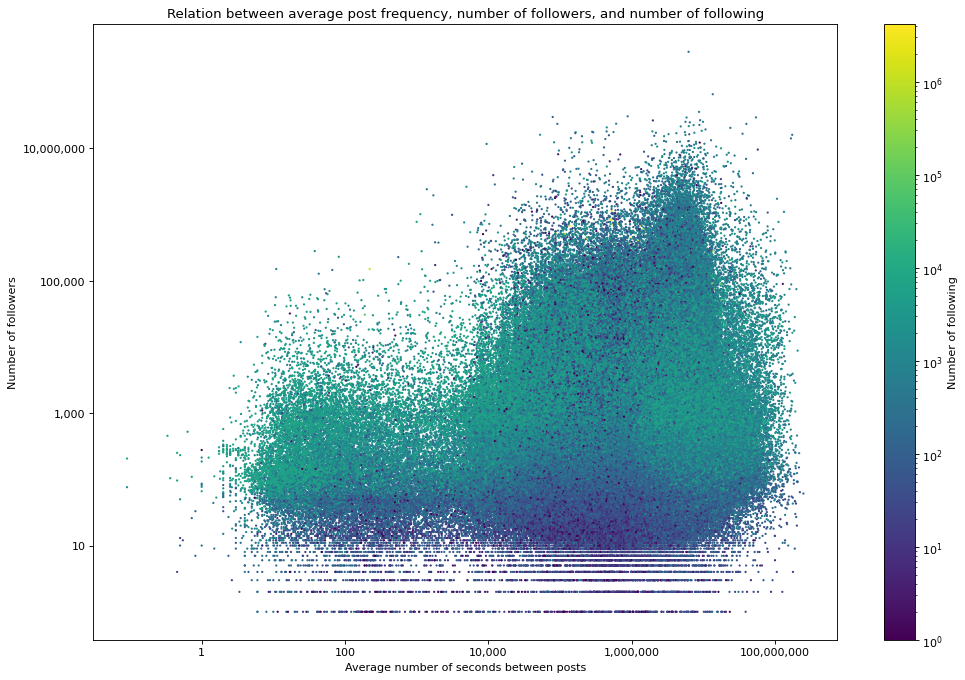

In [18]:
plt.figure(figsize=(15, 10), dpi=80)

plt.scatter(seconds, followers, c=following, norm=LogNorm(), s=1)
plt.yscale('log')
plt.xscale('log')
plt.title('Relation between average post frequency, number of followers, and number of following')
plt.xlabel('Average number of seconds between posts')
plt.ylabel('Number of followers')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.colorbar(label='Number of following');

### Using the function you previously coded, plot the time intervals with the highest average number of “likes” and the ones with the highest average number of comments on posts.

For this we need to grab a subset from the already fetched posts dataset, with the following columns:
* post time (`cts`)
* number of likes (`numbr_likes`)
* number of comments (`number_comments`)

from the posts dataset.

In [19]:
time_likes_comments = posts[['cts', 'numbr_likes', 'number_comments']]

### Find the average number of likes and comments

In [20]:
intervals = [("06:00:00", "10:59:59"), ("11:00:00", "13:59:59"), ("14:00:00", "16:59:59"), ("17:00:00", "19:59:59"), ("20:00:00", "23:59:59"), ("00:00:00", "02:59:59"), ("03:00:00",  "05:59:59")]
intervals.sort()

In [21]:
likes = []
comments = []
for start, end in tqdm(intervals):
    found_posts = find_posts_between(posts, start, end)
    
    n_posts = found_posts.shape[0]
    
    avg_likes = found_posts.numbr_likes.sum() / n_posts
    avg_comments = found_posts.number_comments.sum() / n_posts
    likes.append(round(avg_likes))
    comments.append(round(avg_comments))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:21<00:00, 28.83s/it]


In [22]:
interval_labels = list(map(lambda start_end: f"{start_end[0]} - {start_end[1]}", intervals))

### Plot the likes and comments
The average number of likes and comments is evenly distributed across all time intervals. The average tells us that irregardless of when a post is being posted, users on average will like and comment on the same number of posts.

Just by looking at the average however, one cannot say how likes and comments are distributed.

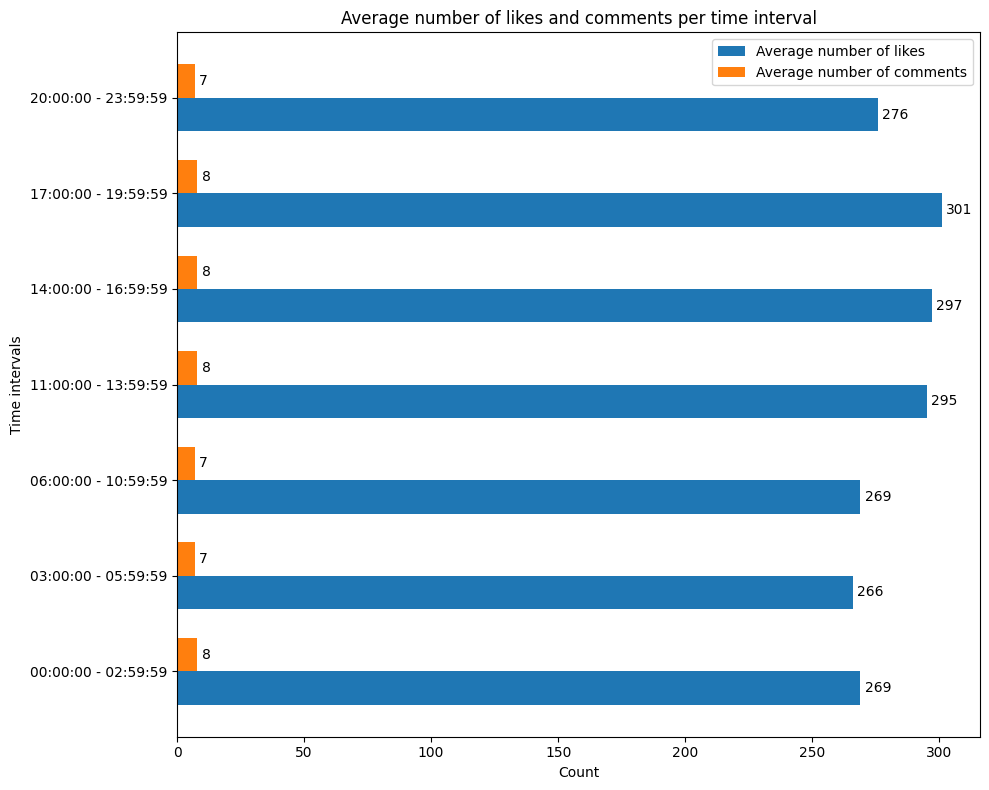

In [23]:
label_locations = np.arange(len(interval_labels))
bar_width = 0.35

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

bar_likes = ax.barh(label_locations - bar_width/2, likes, bar_width, label='Average number of likes')
bar_comments = ax.barh(label_locations + bar_width/2, comments, bar_width, label='Average number of comments')

ax.set_ylabel('Time intervals')
ax.set_yticks(label_locations, interval_labels)

ax.set_xlabel('Count')
ax.set_title('Average number of likes and comments per time interval')
ax.legend()

ax.bar_label(bar_likes, padding=3)
ax.bar_label(bar_comments, padding=3)

fig.tight_layout()

plt.show()